<p style="font-family: 'Courier New', Courier, monospace; font-size: 50px; font-weight: bold; color: blue;  text-align: center;">
  LoRaWAN Path Loss Measurements in an Indoor Setting: EXPLORATORY DATA ANALYSIS
</p>

<div style="text-align: center;">
    <img src="lorawan.png" alt="LoRaWAN">
    <div style="text-align: right;">Photo Credit: <a href="https://onesight.solutions/wp-content/uploads/2023/10/LoraWAN-Test-Kit-Sales-Tech-Rev-2.pdf">Here</a></div>
</div>


In [3]:
# Libraries/Packages Used:

import pandas as pd                # For data manipulation and analysis.
import numpy as np                 # For numerical computations and handling arrays.
import seaborn as sns              # For statistical data visualization based on matplotlib.
from datetime import datetime, timedelta  # For handling date and time operations.
import matplotlib.pyplot as plt    # For creating static visualizations.
import plotly.graph_objs as go     # For creating interactive visualizations.
from plotly.subplots import make_subplots  # For creating interactive subplots.
import itertools                   # To cycle through colors / other iterables.
import math

In [4]:
# Run the Data_Querying notebook to fetch and prepare the data
#%run "Data_Querying.ipynb"

In [5]:
# Read data from a local CSV file
new_df = pd.read_csv('../all_data_files/combined_measurements_data.csv')

# Print the info about the combined DataFrame
print("\nInfo of Combined DataFrame:\n")
new_df.info()


Info of Combined DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147077 entries, 0 to 147076
Data columns (total 71 columns):
 #   Column                                                   Non-Null Count   Dtype  
---  ------                                                   --------------   -----  
 0   time                                                     147077 non-null  object 
 1   correlation_ids_0                                        147077 non-null  object 
 2   device_id                                                147077 non-null  object 
 3   end_device_ids_application_ids_application_id            147077 non-null  object 
 4   end_device_ids_dev_addr                                  147077 non-null  object 
 5   end_device_ids_dev_eui                                   147077 non-null  object 
 6   end_device_ids_device_id                                 147077 non-null  object 
 7   end_device_ids_join_eui                                  147077 non-nul

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Creating the assorted/aggregated measurements Dataframe
</p>

In [7]:
# Columns to keep and their new names for better readability
columns_to_keep = {
    'time': 'time',
    'end_device_ids_device_id': 'device_id',
    'uplink_message_decoded_payload_co2': 'co2',
    'uplink_message_decoded_payload_humidity': 'humidity',
    'uplink_message_decoded_payload_pm25': 'pm25',
    'uplink_message_decoded_payload_pressure': 'pressure',
    'uplink_message_decoded_payload_temperature': 'temperature',
    'uplink_message_rx_metadata_0_rssi': 'rssi',
    'uplink_message_rx_metadata_0_snr': 'snr',
    'uplink_message_settings_data_rate_lora_spreading_factor': 'SF',
    'uplink_message_settings_frequency': 'frequency',
    'uplink_message_f_cnt': 'f_count',
    'uplink_message_decoded_payload_packetCount' : 'p_count',
    'uplink_message_consumed_airtime' : 'toa'
}

# Select and rename columns to keep the dataset clean and focused
cleaned_df = new_df[list(columns_to_keep.keys())].rename(columns=columns_to_keep)

# Add a 'distance' column based on device_id values
distance_map = {
    'pilotdevice'  : 10,
    'pilotdevice01': 8,
    'pilotdevice02': 25,
    'pilotdevice03': 18,
    'pilotdevice04': 37,
    'pilotdevice05': 40
}

# Map the distances to the devices
cleaned_df['distance'] = cleaned_df['device_id'].map(distance_map)

# Define the mapping for c_walls and w_walls
wall_counts_map = {
    'pilotdevice': (0, 0),
    'pilotdevice01': (1, 0),
    'pilotdevice02': (0, 2),
    'pilotdevice03': (1, 2),
    'pilotdevice04': (0, 5),
    'pilotdevice05': (2, 2)
}

# Map the c_walls and w_walls columns using the provided tuple mapping
cleaned_df[['c_walls', 'w_walls']] = cleaned_df['device_id'].map(wall_counts_map).apply(pd.Series)

# Shorten the device names for easier reference
device_name_map = {
    'pilotdevice'  : 'ED0',
    'pilotdevice01': 'ED1',
    'pilotdevice02': 'ED2',
    'pilotdevice03': 'ED3',
    'pilotdevice04': 'ED4',
    'pilotdevice05': 'ED5'
}

# Apply the name mapping so that devices now use shorter names
cleaned_df['device_id'] = cleaned_df['device_id'].map(device_name_map)

# Convert the frequency column to numeric (handling any errors) and convert to MHz
cleaned_df['frequency'] = pd.to_numeric(cleaned_df['frequency'], errors='coerce')
cleaned_df['frequency'] = cleaned_df['frequency'] / 1e6  # Hz to MHz

# Clean up the 'toa' column by removing the 's' at the end and converting to float
cleaned_df['toa'] = cleaned_df['toa'].str.rstrip('s').astype(float)

# Adding the 'experimental_PL' column based on the provided constants and formula
cleaned_df = cleaned_df.assign(
    exp_pl = 14 - 1 + 1.4 + 3 - cleaned_df['rssi']  
    # Using the exact values: tx_p=14, tx_cl=1, tx_ag=1.4, rx_ag=3
)

# If you'd like to display or further use the cleaned_df, you can add any additional code here.


# Save the cleaned and aggregated data to a CSV file for future analysis
cleaned_df.to_csv('aggregated_measurements_data.csv', index=False)

# Display DataFrame information to confirm everything looks good
cleaned_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147077 entries, 0 to 147076
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   time         147077 non-null  object 
 1   device_id    147077 non-null  object 
 2   co2          147077 non-null  float64
 3   humidity     147077 non-null  float64
 4   pm25         147077 non-null  float64
 5   pressure     147077 non-null  float64
 6   temperature  147077 non-null  float64
 7   rssi         147077 non-null  float64
 8   snr          146737 non-null  float64
 9   SF           147077 non-null  float64
 10  frequency    147077 non-null  float64
 11  f_count      147077 non-null  float64
 12  p_count      147077 non-null  float64
 13  toa          147077 non-null  float64
 14  distance     147077 non-null  int64  
 15  c_walls      147077 non-null  int64  
 16  w_walls      147077 non-null  int64  
 17  exp_pl       147077 non-null  float64
dtypes: float64(13), int64(3)

C:\Users\User\AppData\Local\Temp\ipykernel_12520\1298071955.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=channel_counts.index, y=channel_counts.values, palette='viridis')


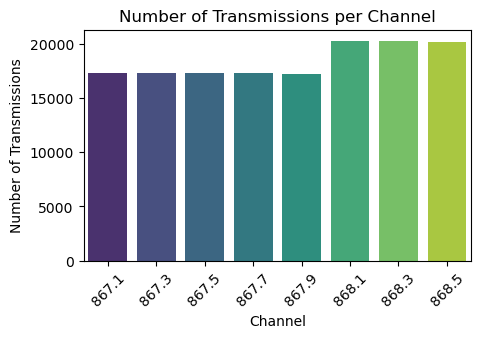

In [8]:
# Count transmissions per channel
channel_counts = cleaned_df['frequency'].value_counts().sort_index()

# Plotting the distribution
plt.figure(figsize=(5,3))
sns.barplot(x=channel_counts.index, y=channel_counts.values, palette='viridis')
plt.title('Number of Transmissions per Channel')
plt.xlabel('Channel')
plt.ylabel('Number of Transmissions')
plt.xticks(rotation=45)
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Packet Delivery Ratio (PDR)
</p>

In [10]:
# Grouping data by device_id
grouped = cleaned_df.groupby('device_id')

# Calculating the total sent and received packets
pdr_table = grouped.agg(
    total_sent_packets=('p_count', 'max'),
    received_packets=('f_count', 'max')
)

# Calculating the PDR
pdr_table['PDR (%)'] = (pdr_table['received_packets'] / pdr_table['total_sent_packets']) * 100

# Displaying the result as a table
pdr_table


,total_sent_packets,received_packets,PDR (%)
device_id,,,
ED0,26200.0,23473.0,89.591603
ED1,26199.0,23395.0,89.297301
ED2,26204.0,23301.0,88.921539
ED3,26197.0,23336.0,89.078902
ED4,30313.0,26687.0,88.038135
ED5,30326.0,27820.0,91.736464


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Visual Dataframe Cleaning
</p>

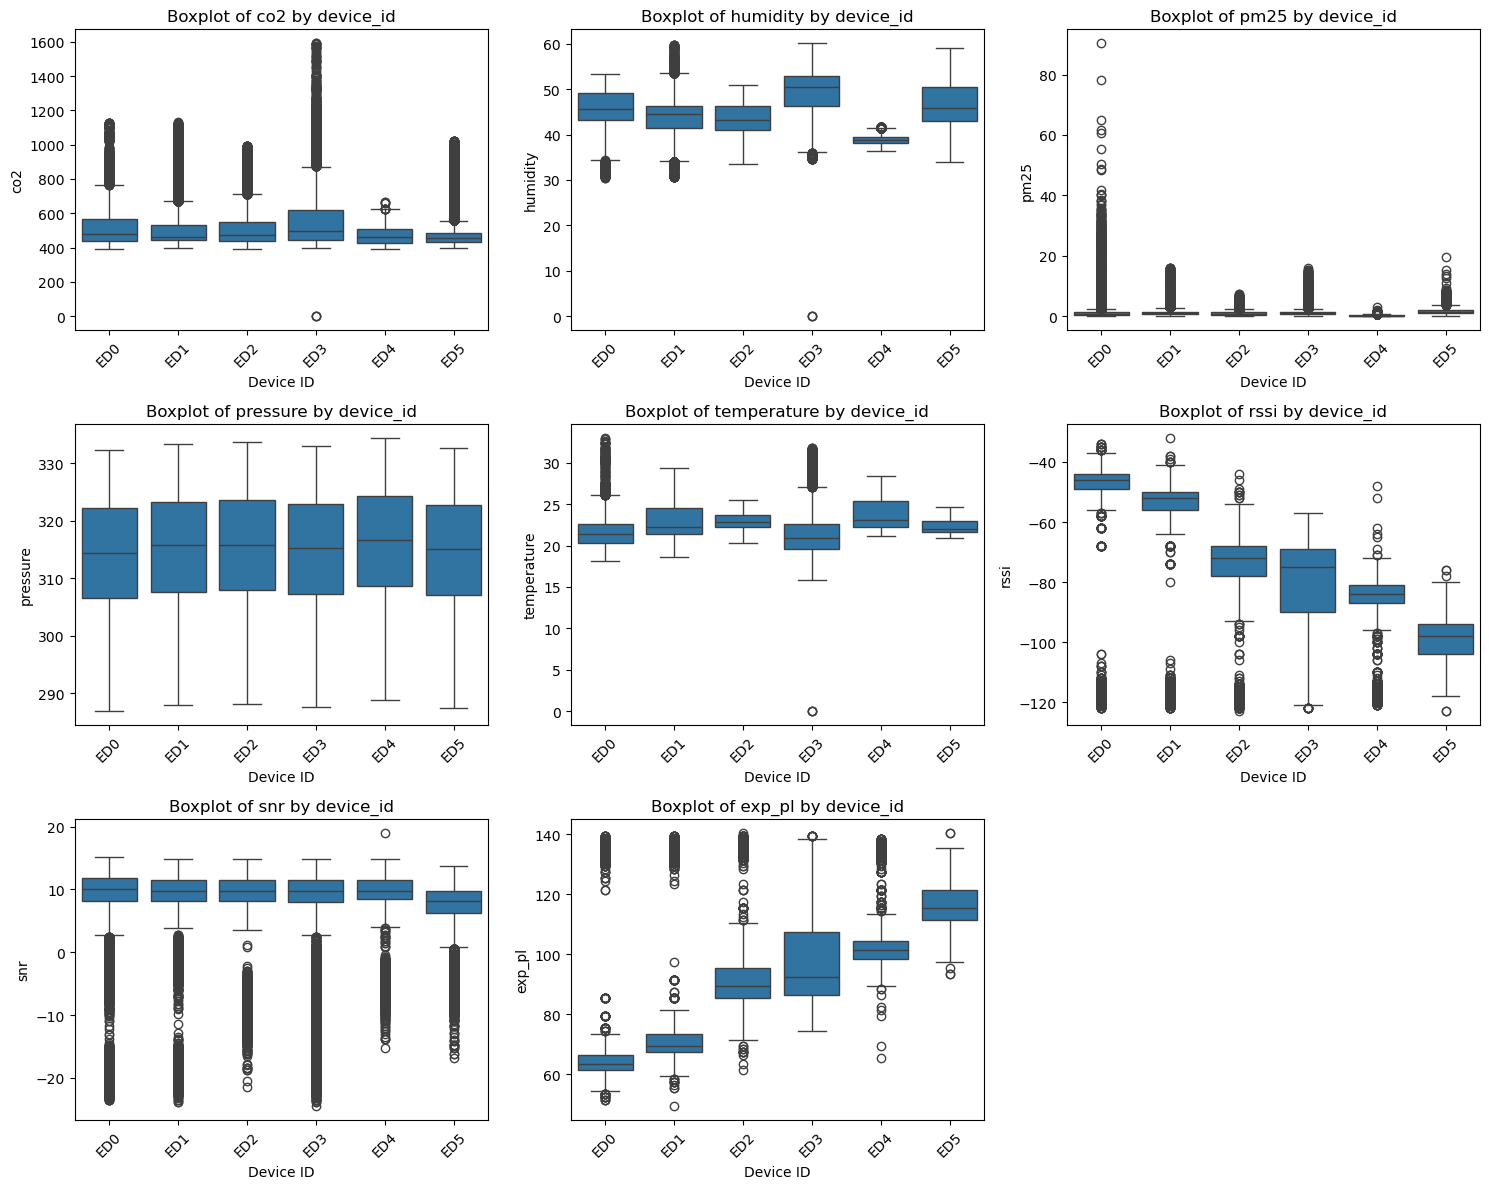

In [12]:
#BOX PLOTS
# Define columns to exclude
exclude_cols = ['f_count', 'p_count', 'c_walls', 'w_walls', 'frequency', 'SF', 'toa', 'distance']

# Select numeric columns excluding 'f_count' and 'p_count'
numeric_cols = cleaned_df.select_dtypes(include=['float64', 'int64']).columns.drop(exclude_cols)

# Define the desired order for device_id
desired_order = ['ED0', 'ED1', 'ED2', 'ED3', 'ED4', 'ED5']  # Modify as per your actual device_ids

# Ensure 'device_id' is a categorical type with the specified order
cleaned_df['device_id'] = pd.Categorical(cleaned_df['device_id'], categories=desired_order, ordered=True)

# Determine the number of plots
num_vars = len(numeric_cols)
cols = 3  # Number of columns in the subplot grid
rows = math.ceil(num_vars / cols)

# Set the overall figure size
plt.figure(figsize=(cols * 5, rows * 4))

# Iterate over each numeric column and create a subplot
for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, idx)
    sns.boxplot(x='device_id', y=col, data=cleaned_df, order=desired_order)
    plt.title(f'Boxplot of {col} by device_id')
    plt.xlabel('Device ID')
    plt.ylabel(col)
    plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [13]:
# Exclude all rows where 'rssi' looks anomalous
# cleaned_df = cleaned_df[cleaned_df['rssi'] > -116]

# Define RSSI thresholds for each device
rssi_thresholds = {
    'ED0': -100.0,
    'ED1': -100.0,
    'ED2': -100.0,
    'ED3': -130.0,
    'ED4': -116.0,
    'ED5': -131.0
}

# Apply the thresholds using the map and filter the DataFrame
#cleaned_df = cleaned_df[cleaned_df['rssi'] > cleaned_df['device_id'].map(rssi_thresholds)]

# Resetting the index after filtering
#cleaned_df.reset_index(drop=True, inplace=True)

# Exclude data points for device ED4
#cleaned_df = cleaned_df[~cleaned_df['device_id'].isin(['ED4'])]

# Exclude both SF11 and SF12 datapoints
cleaned_df = cleaned_df[~cleaned_df['SF'].isin([12])]

# Remove rows with a temperature above 30
#cleaned_df = cleaned_df[~(cleaned_df['temperature'] > 30)]
# Remove rows with humidity below 20
#cleaned_df = cleaned_df[~(cleaned_df['humidity'] < 20)]


# Remove rows with SNR that is negative
#cleaned_df = cleaned_df[~(cleaned_df['snr'] < -3)]

# Save all data to csv
cleaned_df.to_csv('../all_data_files/visually_cleaned_df.csv', index=False)

# Display the cleaned Dataframe Info
print("\nInfo of Combined DataFrame:\n")
cleaned_df.info()

# Display the cleaned Dataframe Head and Tail
print("\nCleaned DataFrame:\n")
cleaned_df



Info of Combined DataFrame:

<class 'pandas.core.frame.DataFrame'>
Index: 125744 entries, 0 to 147076
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   time         125744 non-null  object  
 1   device_id    125744 non-null  category
 2   co2          125744 non-null  float64 
 3   humidity     125744 non-null  float64 
 4   pm25         125744 non-null  float64 
 5   pressure     125744 non-null  float64 
 6   temperature  125744 non-null  float64 
 7   rssi         125744 non-null  float64 
 8   snr          125579 non-null  float64 
 9   SF           125744 non-null  float64 
 10  frequency    125744 non-null  float64 
 11  f_count      125744 non-null  float64 
 12  p_count      125744 non-null  float64 
 13  toa          125744 non-null  float64 
 14  distance     125744 non-null  int64   
 15  c_walls      125744 non-null  int64   
 16  w_walls      125744 non-null  int64   
 17  exp_pl       125744 non

,time,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl
0,2024-09-26 13:00:52.541686+02:00,ED3,633.0,54.22,0.58,300.41,23.85,-71.0,12.2,10.0,867.9,94.0,104.0,0.452608,18,1,2,88.4
1,2024-09-26 13:00:52.542462+02:00,ED3,633.0,54.22,0.58,300.41,23.85,-71.0,12.2,10.0,867.9,94.0,104.0,0.452608,18,1,2,88.4
2,2024-09-26 13:01:08.336258+02:00,ED0,541.0,49.34,0.46,299.70,24.57,-52.0,13.2,9.0,868.1,81.0,108.0,0.246784,10,0,0,69.4
3,2024-09-26 13:01:08.338296+02:00,ED0,541.0,49.34,0.46,299.70,24.57,-52.0,13.2,9.0,868.1,81.0,108.0,0.246784,10,0,0,69.4
4,2024-09-26 13:01:14.477162+02:00,ED1,475.0,45.28,0.23,300.73,25.63,-58.0,8.5,9.0,867.5,80.0,106.0,0.246784,8,1,0,75.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147072,2024-10-14 16:30:15.715979+02:00,ED2,967.0,41.17,4.56,321.31,23.87,-69.0,8.0,10.0,867.5,23301.0,26204.0,0.452608,25,0,2,86.4
147073,2024-10-14 16:30:33.086571+02:00,ED5,960.0,45.97,5.06,320.46,21.49,-97.0,3.8,7.0,867.5,27820.0,30326.0,0.071936,40,2,2,114.4
147074,2024-10-14 16:30:34.281342+02:00,ED4,484.0,40.70,0.29,322.13,21.14,-84.0,12.0,10.0,867.9,26687.0,30313.0,0.452608,37,0,5,101.4
147075,2024-10-14 16:31:01.073884+02:00,ED3,1122.0,45.68,4.69,320.63,22.52,-120.0,-10.0,11.0,867.5,23336.0,26197.0,0.987136,18,1,2,137.4


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Plot for Some Dataframe variables over time
</p>

In [15]:
def plot_sensor_readings(cleaned_df, row_map):
    """
    Plots sensor readings by grouping devices and assigning colors dynamically.
    Ensures the plot is fully visible in Jupyter notebooks without scrolling.

    Args:
    - cleaned_df (DataFrame): Cleaned DataFrame containing sensor data.
    - row_map (dict): Mapping of sensor parameters to subplot rows.
    """
    # Create subplots dynamically based on the row_map provided
    fig = make_subplots(
        rows=len(row_map), cols=1, 
        subplot_titles=[f'{param.title()} Readings Over Time' for param in row_map]
    )

    # Define a pool of colors and create an iterator to cycle through them
    color_pool = itertools.cycle(['green', 'red', 'blue', 'purple', 'orange', 
                                  'cyan', 'magenta', 'brown', 'black', 'pink'])
    
    # Group by unique device IDs and assign colors dynamically
    device_colors = {device: next(color_pool) for device in cleaned_df['device_id'].unique()}

    # Set to track which devices have already been added to the legend
    devices_in_legend = set()

    # Plotting for each parameter and each device
    for param, row in row_map.items():
        for device, color in device_colors.items():
            # Filter data for the specific device
            data = cleaned_df[cleaned_df['device_id'] == device]
            
            # Add a trace for each parameter for the current device
            fig.add_trace(
                go.Scatter(
                    x=data['time'], 
                    y=data[param], 
                    mode='lines',  # Line plot
                    name=f"{device}" if device not in devices_in_legend else None,  # Add device to legend once
                    line=dict(color=color),
                    showlegend=device not in devices_in_legend  # Only show legend if the device hasn't been added yet
                ),
                row=row, col=1  # Place in the correct subplot
            )

            # Mark the device as added to the legend
            devices_in_legend.add(device)

    # Update layout with fixed height and other settings
    fig.update_layout(
        height=1800,  # Fixed height to accommodate all subplots
        showlegend=True,  # Show legend
        title_text="Sensor Readings Over Time",  # Overall plot title
        legend=dict(title="Devices", x=1.05, y=1)  # Adjust legend position
    )

    # Show the plot
    fig.show()

# Example usage:
# Define the row mapping for parameters; you can modify this as needed
row_map = {
    'temperature': 1, 'humidity': 2, 'co2': 3, 'pm25': 4, 
    'pressure': 5, 'rssi': 6, 'snr': 7, 'p_count': 8, 'f_count': 9
}

# Call the function with the cleaned DataFrame and row_map
#plot_sensor_readings(cleaned_df, row_map)


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold;
color: blue;  text-align: left;">
  Statistical Description
</p>

In [17]:
# Generate the statistical description of the cleaned DataFrame
stat_description = cleaned_df.describe().transpose()

# Set the display format for floating-point numbers to xx decimal places
pd.options.display.float_format = '{:,.3f}'.format 

# Save the statistical description to an Excel file
excel_path = "statistical_description.xlsx"
stat_description.to_excel(excel_path)

# Display the statistical description
stat_description

,count,mean,std,min,25%,50%,75%,max
co2,"125,744.000",504.708,107.332,0.000,437.000,467.000,532.000,"1,593.000"
humidity,"125,744.000",44.666,5.160,0.000,40.660,44.420,48.270,60.190
pm25,"125,744.000",1.101,1.536,0.000,0.410,0.800,1.350,78.080
pressure,"125,744.000",315.092,9.528,286.910,307.760,315.590,323.030,334.370
temperature,"125,744.000",22.458,1.990,0.000,21.400,22.230,23.640,33.010
rssi,"125,744.000",-73.879,21.317,-123.000,-88.000,-74.000,-52.000,-32.000
snr,"125,579.000",9.072,4.521,-21.800,8.500,10.000,11.500,19.000
SF,"125,744.000",8.867,1.385,7.000,8.000,9.000,10.000,11.000
frequency,"125,744.000",867.818,0.460,867.100,867.500,867.900,868.300,868.500
f_count,"125,744.000","11,453.021","7,177.621",76.000,"5,118.000","11,135.000","17,284.000","27,820.000"


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold;
color: blue;  text-align: left;">
  Correlation Matrix and the HeatMap
</p>

In [19]:
# Select only the numeric columns
numeric_df = cleaned_df.select_dtypes(include='number')

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Set the display format for floating-point numbers to xx decimal places
pd.options.display.float_format = '{:,.3f}'.format 

# Display the Correlation Matrix
correlation_matrix

,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl
co2,1.000,0.334,0.361,-0.152,-0.011,0.112,0.048,-0.002,-0.003,0.237,0.237,-0.000,-0.177,-0.012,-0.126,-0.112
humidity,0.334,1.000,0.074,-0.484,-0.467,0.057,-0.015,0.003,-0.000,0.157,0.145,0.002,-0.210,0.323,-0.346,-0.057
pm25,0.361,0.074,1.000,0.122,-0.056,0.032,-0.006,0.002,-0.001,0.108,0.101,0.001,-0.078,0.192,-0.222,-0.032
pressure,-0.152,-0.484,0.122,1.000,-0.122,-0.040,-0.009,0.002,0.001,0.046,0.047,0.002,0.028,-0.023,0.051,0.040
temperature,-0.011,-0.467,-0.056,-0.122,1.000,-0.111,-0.026,-0.002,0.001,-0.408,-0.404,-0.003,0.202,-0.113,0.259,0.111
rssi,0.112,0.057,0.032,-0.040,-0.111,1.000,0.550,-0.070,0.020,-0.094,-0.089,-0.078,-0.724,-0.395,-0.544,-1.000
snr,0.048,-0.015,-0.006,-0.009,-0.026,0.550,1.000,-0.079,-0.065,0.050,0.053,-0.157,-0.103,-0.139,-0.009,-0.550
SF,-0.002,0.003,0.002,0.002,-0.002,-0.070,-0.079,1.000,0.058,0.003,0.003,0.914,0.005,0.009,-0.003,0.070
frequency,-0.003,-0.000,-0.001,0.001,0.001,0.020,-0.065,0.058,1.000,-0.000,-0.000,0.072,0.005,0.006,0.001,-0.020
f_count,0.237,0.157,0.108,0.046,-0.408,-0.094,0.050,0.003,-0.000,1.000,1.000,0.003,0.221,0.102,0.157,0.094


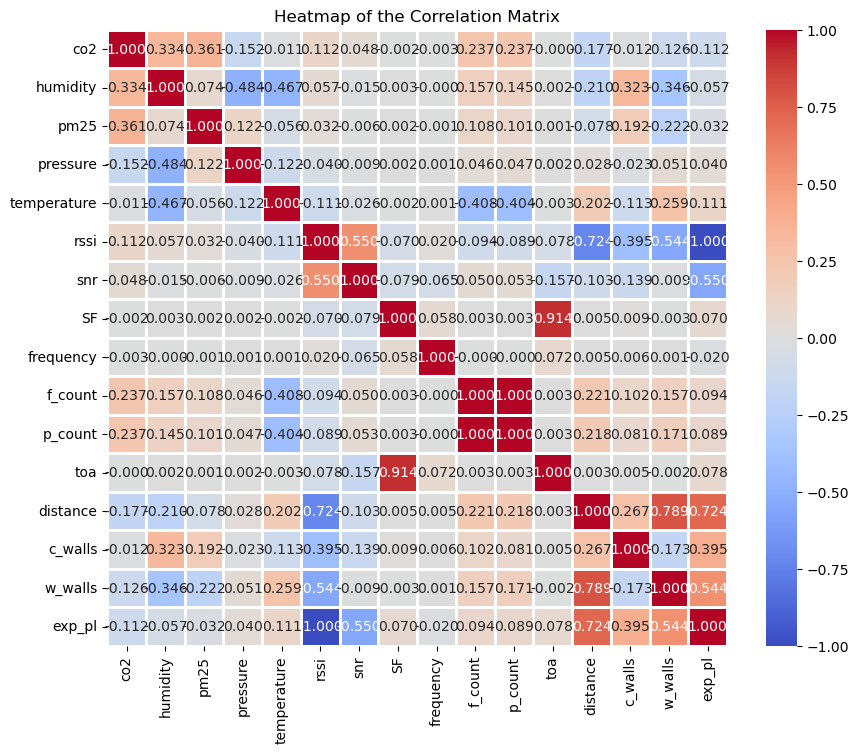

In [20]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.8)
plt.title('Heatmap of the Correlation Matrix')
plt.show()

In [21]:
#Single out RSSI and sort the values
numeric_df.corr()['rssi'].sort_values()

exp_pl        -1.000
distance      -0.724
w_walls       -0.544
c_walls       -0.395
temperature   -0.111
f_count       -0.094
p_count       -0.089
toa           -0.078
SF            -0.070
pressure      -0.040
frequency      0.020
pm25           0.032
humidity       0.057
co2            0.112
snr            0.550
rssi           1.000
Name: rssi, dtype: float64

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Scatter Plots : SNR vs RSSI for each Devices
</p>

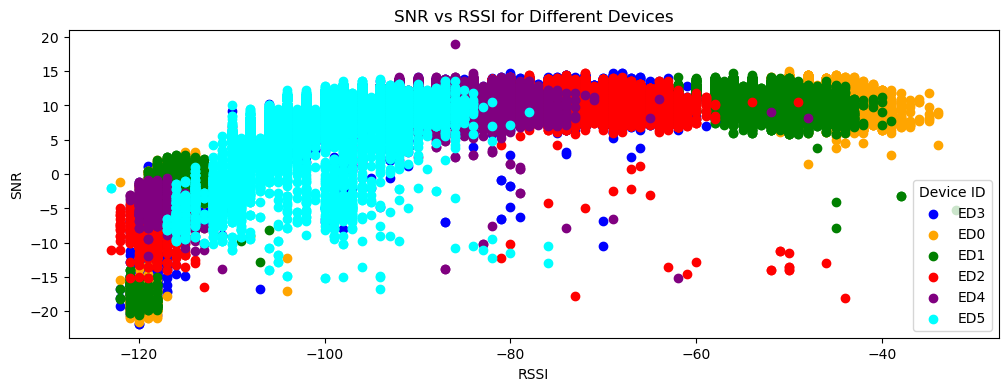

In [23]:
def plot_snr_vs_rssi(cleaned_df):
    """
    Plots SNR vs RSSI for each device dynamically using different colors.

    Args:
    - cleaned_df (DataFrame): Cleaned DataFrame containing sensor data with 'rssi' and 'snr' columns.
    """
    # Define a pool of colors and create an iterator to cycle through them
    color_pool = itertools.cycle(['blue', 'orange', 'green', 'red', 'purple', 
                                  'cyan', 'magenta', 'brown', 'black', 'pink'])

    # Create a figure for plotting
    plt.figure(figsize=(12, 4))

    # Group by unique device IDs and assign colors dynamically
    for device, color in zip(cleaned_df['device_id'].unique(), color_pool):
        # Filter data for each device
        subset = cleaned_df[cleaned_df['device_id'] == device]
        # Scatter plot for SNR vs RSSI
        plt.scatter(subset['rssi'], subset['snr'], label=device, color=color)

    # Add labels, legend, and title
    plt.xlabel('RSSI')
    plt.ylabel('SNR')
    plt.legend(title='Device ID')
    plt.title('SNR vs RSSI for Different Devices')

    # Show the plot
    plt.show()

# Example usage:
plot_snr_vs_rssi(cleaned_df)


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Exploration of LoRAWAN Parameters based on the Spreading Factor
</p>

C:\Users\User\AppData\Local\Temp\ipykernel_12520\1009993336.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for device_id, device_data in cleaned_df.groupby('device_id'):


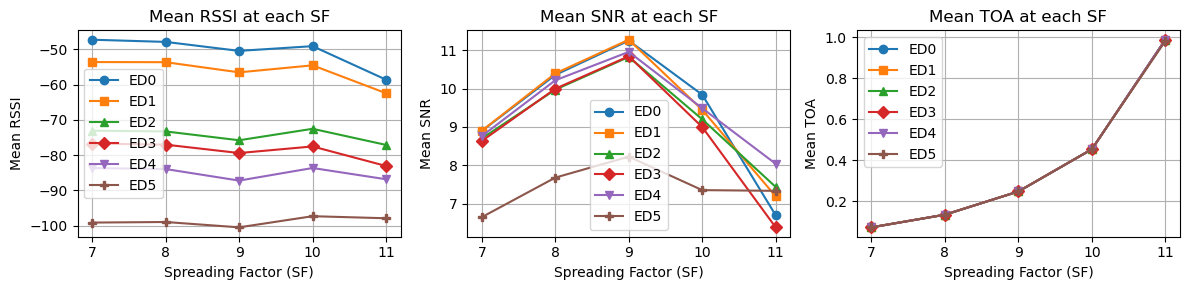

In [25]:
def plot_mean_metric(ax, cleaned_df, metric, ylabel, title):
    """
    Plots the mean of a specified metric grouped by Spreading Factor (SF) for each device.

    Args:
    - ax (Axes): Matplotlib Axes object to plot on.
    - cleaned_df (DataFrame): DataFrame containing sensor data with 'device_id', 'SF', and metric columns.
    - metric (str): The metric to plot (e.g., 'rssi', 'snr', 'toa').
    - ylabel (str): The label for the y-axis.
    - title (str): The title of the plot.
    """
    # Define a pool of markers to use for different devices
    marker_pool = itertools.cycle(['o', 's', '^', 'D', 'v', 'P', '*'])
    
    # Group by device and calculate mean metric for each SF
    for device_id, device_data in cleaned_df.groupby('device_id'):
        mean_metric = device_data.groupby('SF')[metric].mean()
        # Plot mean metric for each device with a different marker
        ax.plot(mean_metric.index, mean_metric.values, marker=next(marker_pool), linestyle='-', label=device_id)
    
    # Set labels and title
    ax.set_xlabel('Spreading Factor (SF)')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

# Set up the matplotlib figure with subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# Plot mean RSSI
plot_mean_metric(axes[0], cleaned_df, 'rssi', 'Mean RSSI', 'Mean RSSI at each SF')

# Plot mean SNR
plot_mean_metric(axes[1], cleaned_df, 'snr', 'Mean SNR', 'Mean SNR at each SF')

# Plot mean TOA
plot_mean_metric(axes[2], cleaned_df, 'toa', 'Mean TOA', 'Mean TOA at each SF')

# Adjust layout
plt.tight_layout()
plt.show()


In [26]:
# Calculate the mean of rssi and snr grouped by device_id
mean_values = cleaned_df.groupby('device_id')[['rssi', 'snr', 'toa', 'exp_pl']].mean()

# Display the mean values
mean_values

C:\Users\User\AppData\Local\Temp\ipykernel_12520\4142559169.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = cleaned_df.groupby('device_id')[['rssi', 'snr', 'toa', 'exp_pl']].mean()


,rssi,snr,toa,exp_pl
device_id,,,,
ED0,-50.296,9.520,0.346,67.696
ED1,-55.822,9.561,0.341,73.222
ED2,-74.237,9.311,0.343,91.637
ED3,-78.547,9.089,0.344,95.947
ED4,-84.983,9.558,0.342,102.383
ED5,-98.802,7.446,0.350,116.202


C:\Users\User\AppData\Local\Temp\ipykernel_12520\2391348934.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_metrics = cleaned_df.groupby('device_id')[metric].mean()


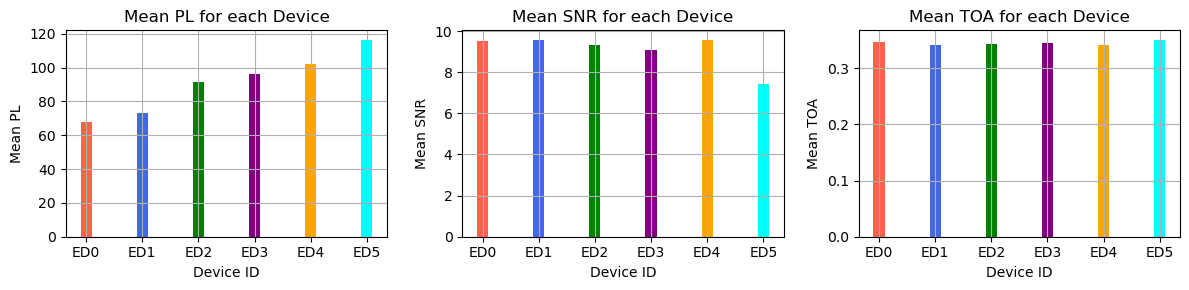

In [27]:
def plot_mean_metric(ax, cleaned_df, metric, ylabel, title, bar_width=0.4):
    """
    Plots the mean of a specified metric for each device as a bar chart.

    Args:
    - ax (Axes): Matplotlib Axes object to plot on.
    - cleaned_df (DataFrame): DataFrame containing sensor data with 'device_id' and metric columns.
    - metric (str): The metric to plot (e.g., 'exp_pl', 'snr', 'toa').
    - ylabel (str): The label for the y-axis.
    - title (str): The title of the plot.
    - bar_width (float): The width of the bars in the bar chart.
    """
    # Define a pool of colors to use for different devices
    color_pool = itertools.cycle(['tomato', 'royalblue', 'green', 'purple', 'orange', 'cyan', 'magenta'])
    
    # Calculate mean metric for each device
    mean_metrics = cleaned_df.groupby('device_id')[metric].mean()

    # Bar plot for each device with a unique color
    ax.bar(mean_metrics.index, mean_metrics.values, color=[next(color_pool) for _ in mean_metrics.index], width=bar_width)
    
    # Set labels and title
    ax.set_xlabel('Device ID')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)

# Set up another matplotlib figure for mean metrics (1 row, 3 columns)
fig2, axes2 = plt.subplots(1, 3, figsize=(12, 3))

# Plot mean PL
plot_mean_metric(axes2[0], cleaned_df, 'exp_pl', 'Mean PL', 'Mean PL for each Device', bar_width=0.2)

# Plot mean SNR
plot_mean_metric(axes2[1], cleaned_df, 'snr', 'Mean SNR', 'Mean SNR for each Device', bar_width=0.2)

# Plot mean TOA
plot_mean_metric(axes2[2], cleaned_df, 'toa', 'Mean TOA', 'Mean TOA for each Device', bar_width=0.2)

# Adjust layout
fig2.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_12520\1492782157.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = data.pivot_table(index=parameter, columns='device_id', aggfunc='size', fill_value=0)
C:\Users\User\AppData\Local\Temp\ipykernel_12520\1492782157.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = data.pivot_table(index=parameter, columns='device_id', aggfunc='size', fill_value=0)
C:\Users\User\AppData\Local\Temp\ipykernel_12520\1492782157.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and ret

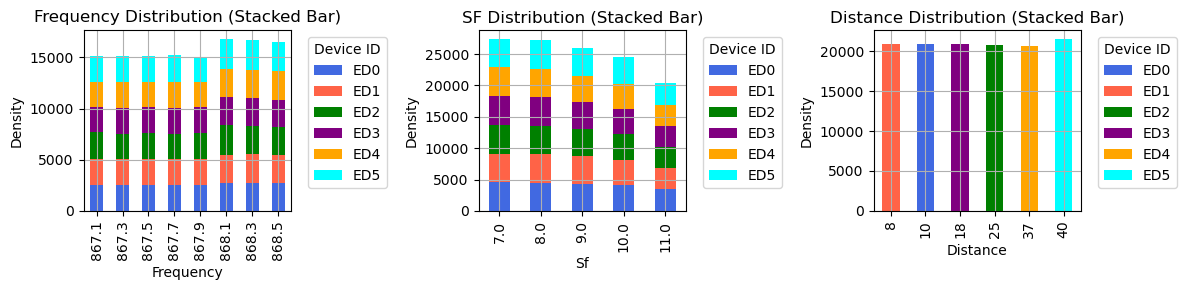

In [28]:
def plot_stacked_bar(ax, data, parameter, title=''):
    """
    Plots a stacked bar chart for the given parameter, grouping by 'device_id'.

    Args:
    - ax (Axes): Matplotlib Axes object to plot on.
    - data (DataFrame): DataFrame containing sensor data with 'device_id' and the parameter to plot.
    - parameter (str): The parameter to plot (e.g., 'frequency', 'SF', 'distance').
    - title (str): The title of the plot.
    """
    # Define a pool of colors to use for different devices
    color_pool = itertools.cycle(['royalblue', 'tomato', 'green', 'purple', 'orange', 'cyan', 'magenta'])
    
    # Pivot the data to have device_id as columns
    pivot_data = data.pivot_table(index=parameter, columns='device_id', aggfunc='size', fill_value=0)
    
    # Create a color map dynamically based on device_id
    colors = {device: next(color_pool) for device in pivot_data.columns}

    # Plot the stacked bar plot
    pivot_data.plot(kind='bar', stacked=True, ax=ax, color=[colors[device] for device in pivot_data.columns])
    
    ax.set_title(title)
    ax.set_xlabel(parameter.capitalize())
    ax.set_ylabel('Density')
    ax.grid(True)
    ax.legend(title='Device ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# Filter the DataFrame (if needed) or use as is
filtered_df = cleaned_df[cleaned_df['device_id'].isin(cleaned_df['device_id'].unique())]

# Set up the matplotlib figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# Plot each parameter on a separate subplot
plot_stacked_bar(axes[0], filtered_df, 'frequency', title='Frequency Distribution (Stacked Bar)')
plot_stacked_bar(axes[1], filtered_df, 'SF', title='SF Distribution (Stacked Bar)')
plot_stacked_bar(axes[2], filtered_df, 'distance', title='Distance Distribution (Stacked Bar)')

# Adjust layout
plt.tight_layout()
plt.show()


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 KDE Plots: Environmental Parameters
</p>

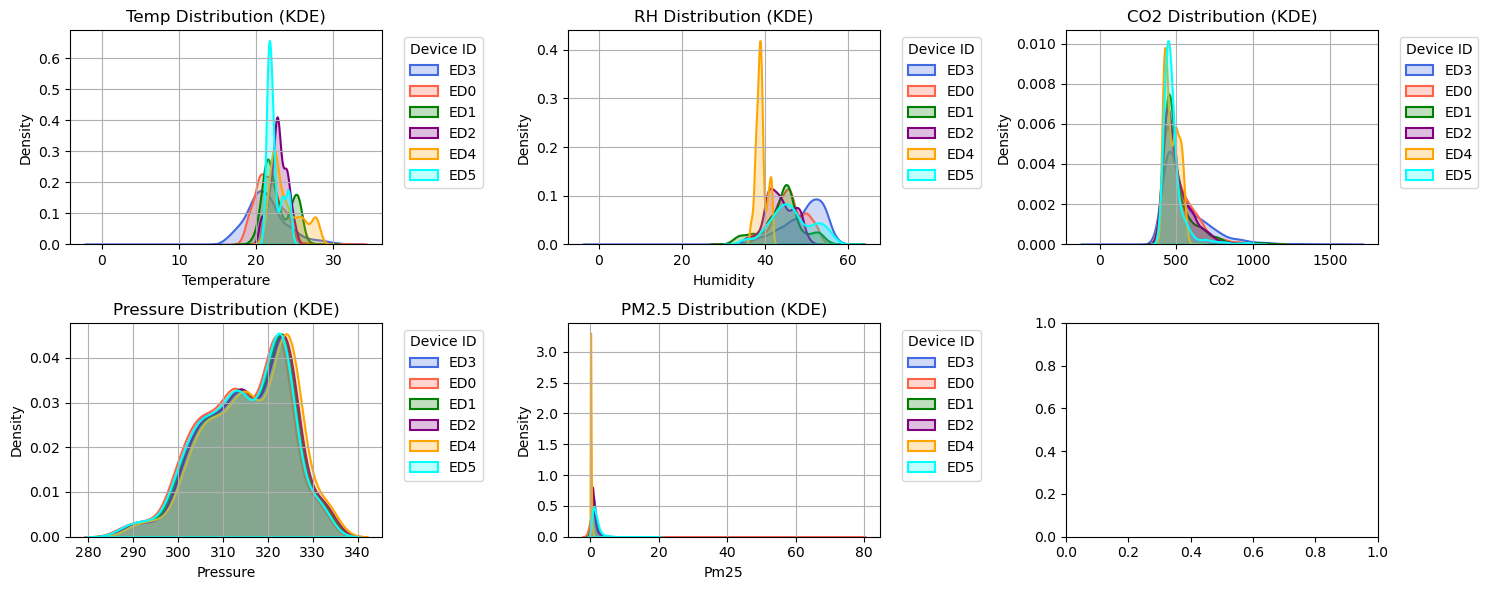

In [30]:
def plot_kde(ax, data, parameter, bw_adjust=2, title=''):
    """
    Plots a Kernel Density Estimate (KDE) for the given parameter, grouped by 'device_id'.

    Args:
    - ax (Axes): Matplotlib Axes object to plot on.
    - data (DataFrame): DataFrame containing sensor data with 'device_id' and the parameter to plot.
    - parameter (str): The parameter to plot (e.g., 'temperature', 'humidity', 'co2').
    - bw_adjust (float): Bandwidth adjustment for the KDE plot.
    - title (str): The title of the plot.
    """
    # Define a pool of colors to use for different devices
    color_pool = itertools.cycle(['royalblue', 'tomato', 'green', 'purple', 'orange', 'cyan', 'magenta'])

    # Create a color map dynamically based on device_id
    colors = {device_id: next(color_pool) for device_id in data['device_id'].unique()}

    # Plot KDE for each device
    for device_id in data['device_id'].unique():
        subset = data[data['device_id'] == device_id]
        sns.kdeplot(
            subset[parameter], ax=ax, 
            label=device_id, 
            lw=1.5, 
            bw_adjust=bw_adjust, 
            fill=True, 
            color=colors[device_id]
        )
    
    ax.set_title(title)
    ax.set_xlabel(parameter.capitalize())
    ax.set_ylabel('Density')
    ax.grid(True)
    ax.legend(title='Device ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# Use the cleaned_df DataFrame as is or filter it as needed
filtered_df = cleaned_df[cleaned_df['device_id'].isin(cleaned_df['device_id'].unique())]

# Set up the matplotlib figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 6))

# Plot each parameter on a separate subplot
plot_kde(axes[0, 0], filtered_df, 'temperature', bw_adjust=2, title='Temp Distribution (KDE)')
plot_kde(axes[0, 1], filtered_df, 'humidity', bw_adjust=2, title='RH Distribution (KDE)')
plot_kde(axes[0, 2], filtered_df, 'co2', bw_adjust=2, title='CO2 Distribution (KDE)')
plot_kde(axes[1, 0], filtered_df, 'pressure', bw_adjust=2, title='Pressure Distribution (KDE)')
plot_kde(axes[1, 1], filtered_df, 'pm25', bw_adjust=2, title='PM2.5 Distribution (KDE)')

# Adjust layout
plt.tight_layout()
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 KDE Plots: LoRaWAN PARAMETERS
</p>

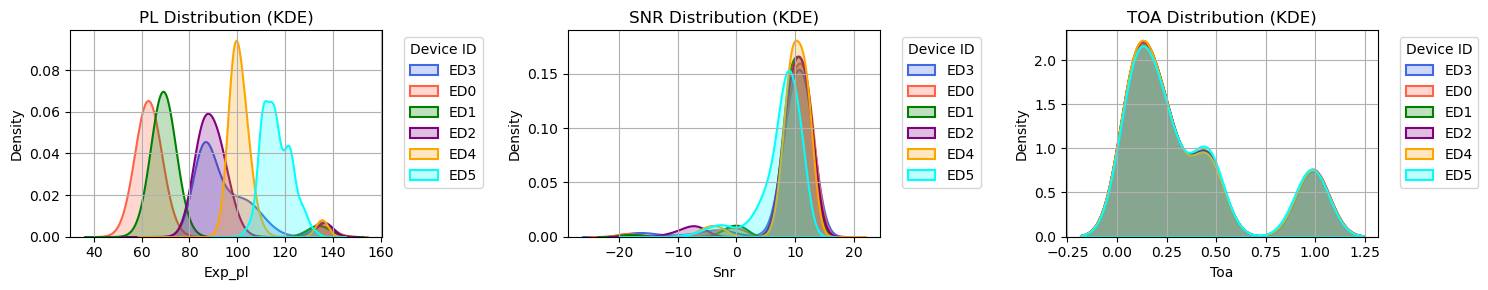

In [32]:
def plot_kde(ax, data, parameter, bw_adjust=2, title=''):
    """
    Plots a Kernel Density Estimate (KDE) for the given parameter, grouped by 'device_id'.

    Args:
    - ax (Axes): Matplotlib Axes object to plot on.
    - data (DataFrame): DataFrame containing sensor data with 'device_id' and the parameter to plot.
    - parameter (str): The parameter to plot (e.g., 'exp_pl', 'snr', 'toa').
    - bw_adjust (float): Bandwidth adjustment for the KDE plot.
    - title (str): The title of the plot.
    """
    # Define a pool of colors to use for different devices
    color_pool = itertools.cycle(['royalblue', 'tomato', 'green', 'purple', 'orange', 'cyan', 'magenta'])

    # Create a color map dynamically based on device_id
    colors = {device_id: next(color_pool) for device_id in data['device_id'].unique()}

    # Plot KDE for each device
    for device_id in data['device_id'].unique():
        subset = data[data['device_id'] == device_id]
        sns.kdeplot(
            subset[parameter], ax=ax, 
            label=device_id, 
            lw=1.5, 
            bw_adjust=bw_adjust, 
            fill=True, 
            color=colors[device_id]
        )
    
    ax.set_title(title)
    ax.set_xlabel(parameter.capitalize())
    ax.set_ylabel('Density')
    ax.grid(True)
    ax.legend(title='Device ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# Use the cleaned_df DataFrame as is or filter it as needed
filtered_df = cleaned_df[cleaned_df['device_id'].isin(cleaned_df['device_id'].unique())]

# Set up the matplotlib figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

# Plot each parameter on a separate subplot
plot_kde(axes[0], filtered_df, 'exp_pl', bw_adjust=2, title='PL Distribution (KDE)')
plot_kde(axes[1], filtered_df, 'snr', bw_adjust=2, title='SNR Distribution (KDE)')
plot_kde(axes[2], filtered_df, 'toa', bw_adjust=2, title='TOA Distribution (KDE)')

# Adjust layout
plt.tight_layout()
plt.show()


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 PLM Modelling and Comaprison
</p>



 Multi-Wall Model Fitting
Total number of rows: 125744
Rows with NaN or Inf: 165 (0.13%)
Rows after cleaning: 125579 (99.87%)

=== Table of Parameters to be Compared ===



,Parameter,LDPLM - MW,LDPLM - MW - EP
0,PL(d0) [dB],25.231,-28.111
1,Path loss exponent (n),4.355,3.705
2,Brick Wall Loss (L_c) [dB],9.095,7.936
3,Wood Wall Loss (L_w) [dB],2.036,2.751
4,CO2 coefficient (a_co2) [dB/unit],-,0.002
5,Humidity coefficient (a_hum) [dB/unit],-,0.046
6,PM2.5 coefficient (a_pm25) [dB/unit],-,-0.102
7,Pressure coefficient (a_pres) [dB/unit],-,0.058
8,Temperature coefficient (a_temp) [dB/unit],-,0.037
9,SNR scaling factor (k_snr),-,2.186



=== Performance Metrics Comparison ===



,LDPLM - MW,LDPLM - MW - EP
RMSE (dB),13.425,9.068
R-squared,0.601,0.818
Shadowing σ (dB),13.239,8.955


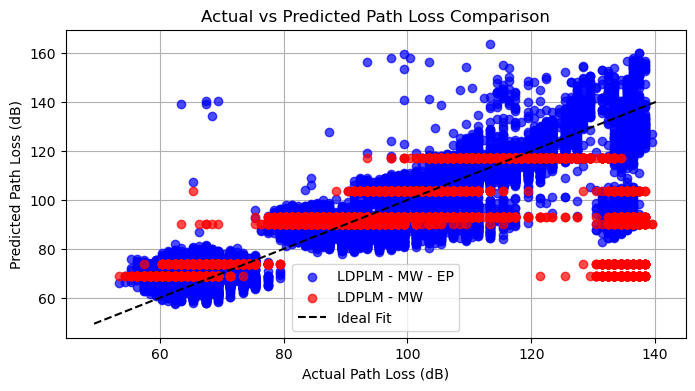

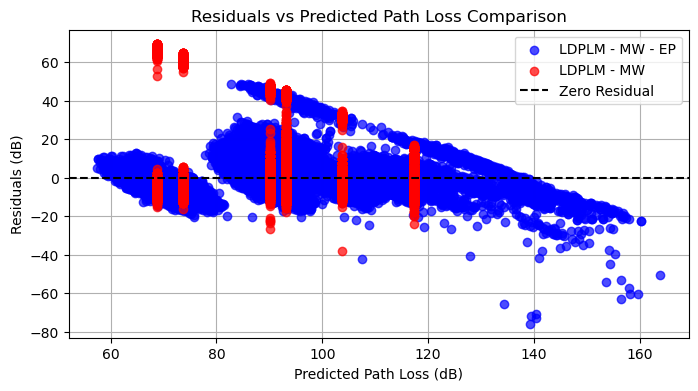

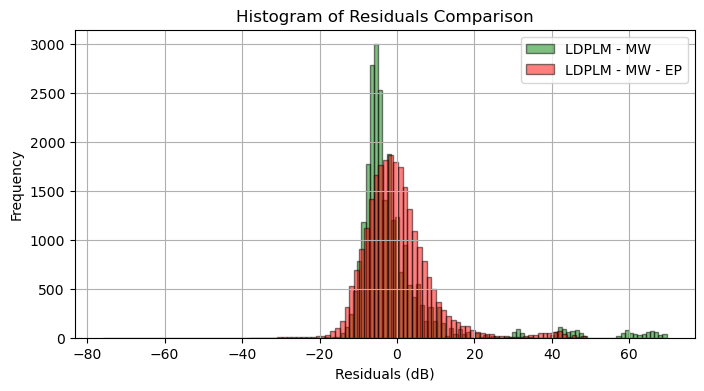


Residual Distribution Values:

LDPLM - MW: Mean:0.035 dB, Skewness: 3.2397 dB
LDPLM - MW - EP: Mean:0.0055 dB, Skewness: 1.4428 dB

=== Cross-Validation (5-Fold) ===

Fold 1: LDPLM - MW RMSE = 13.42 dB, R-squared = 0.6015; LDPLM - MW - EP RMSE = 9.07 dB, R-squared = 0.8182
Fold 2: LDPLM - MW RMSE = 13.26 dB, R-squared = 0.6115; LDPLM - MW - EP RMSE = 8.94 dB, R-squared = 0.8233
Fold 3: LDPLM - MW RMSE = 13.35 dB, R-squared = 0.6077; LDPLM - MW - EP RMSE = 8.93 dB, R-squared = 0.8244
Fold 4: LDPLM - MW RMSE = 13.29 dB, R-squared = 0.6112; LDPLM - MW - EP RMSE = 9.03 dB, R-squared = 0.8205
Fold 5: LDPLM - MW RMSE = 13.06 dB, R-squared = 0.6220; LDPLM - MW - EP RMSE = 8.93 dB, R-squared = 0.8235

Average RMSE across folds:
LDPLM - MW: 13.28 dB
LDPLM - MW - EP: 8.98 dB

Average R-squared across folds:
LDPLM - MW: 0.6108
LDPLM - MW - EP: 0.8220


In [34]:
# Run the two Fitting Models [Multi-wall & the Enhanced]

print('\n\n Multi-Wall Model Fitting')
%run "LDPLM - BOTH.ipynb"
